In [ ]:
!pip -q install librosa==0.10.2.post1 soundfile==0.12.1 \
                 scikit-learn==1.6.0 matplotlib==3.9.0 \
                 lime==0.2.0.1 shap==0.46.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 139.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.9/543.9 kB 41.8 MB/s eta 0:00:00


In [ ]:
# Alzheimer’s Detection — Pure RNN with Regularization + Full Explainable AI
# Audio (MFCC + Spectrogram + Saliency) + Text (TF-IDF + LIME + SHAP)
# Train: 100 Control + 100 Dementia
# Test: Remaining samples | Holdout: 4 Control + 4 Dementia unseen
# Model: Pure bidirectional RNN with L1 + L2 regularization

import os, random, pathlib, warnings, math
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt

import torch, torch.nn as nn
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, accuracy_score,
    roc_auc_score, roc_curve, ConfusionMatrixDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import librosa, librosa.display as lbd
from lime.lime_text import LimeTextExplainer
import shap
from google.colab import drive

# CONFIGURATION
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
EPOCHS = 6
BATCH = 8
MAX_DUR = 12.0
N_MFCC = 40
SAVE_ROOT = pathlib.Path('/content/Alzheimers_RNN_Full_XAI')
SAVE_ROOT.mkdir(parents=True, exist_ok=True)

drive.mount('/content/drive')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", DEVICE)

BASE = pathlib.Path('/content/drive/MyDrive/Alzheimers_Organized')
CONTROL_DIR, DEMENTIA_DIR = BASE/'control', BASE/'dementia'

# DATASET LOADING
def list_pairs(root, label):
    items = []
    for wav in sorted(root.rglob('*.wav')):
        txt = wav.with_suffix('.txt')
        if txt.exists():
            items.append((str(wav), str(txt), label, wav.name))
    print(f"{root.name}: {len(items)} pairs")
    return items

ctl, dem = list_pairs(CONTROL_DIR, 0), list_pairs(DEMENTIA_DIR, 1)
all_items = ctl + dem
print("Total pairs:", len(all_items))

rng = np.random.default_rng(SEED)
def pick(arr, n):
    n = min(n, len(arr))
    return rng.choice(arr, size=n, replace=False).tolist()

idx_ctl = [i for i,(_,_,lab,_) in enumerate(all_items) if lab==0]
idx_dem = [i for i,(_,_,lab,_) in enumerate(all_items) if lab==1]

train_ctl, train_dem = pick(idx_ctl, 100), pick(idx_dem, 100)
train_idx = set(train_ctl + train_dem)
rem_ctl = [i for i in idx_ctl if i not in train_idx]
rem_dem = [i for i in idx_dem if i not in train_idx]
hold_ctl, hold_dem = pick(rem_ctl, 4), pick(rem_dem, 4)
hold_idx = set(hold_ctl + hold_dem)
test_idx = set(i for i in range(len(all_items)) if i not in train_idx | hold_idx)

def gather(idxs):
    wavs, txts, labels, fnames = [], [], [], []
    for i in idxs:
        w,t,l,f = all_items[i]
        wavs.append(w); txts.append(t); labels.append(l); fnames.append(f)
    return wavs, txts, np.array(labels), fnames

tr_wav, tr_txt, tr_y, tr_fn = gather(train_idx)
te_wav, te_txt, te_y, te_fn = gather(test_idx)
ho_wav, ho_txt, ho_y, ho_fn = gather(hold_idx)
print(f"Train={len(tr_y)} | Test={len(te_y)} | Holdout={len(ho_y)}")

# AUDIO FEATURE EXTRACTION
def compute_mfcc(y, sr):
    m = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC).T
    d = librosa.feature.delta(m.T).T
    d2= librosa.feature.delta(d.T).T
    f = np.concatenate([m,d,d2], 1)
    f = (f - f.mean(0)) / (f.std(0)+1e-8)
    return f.astype(np.float32)

class AudioDataset(Dataset):
    def __init__(self, wavs, labels, max_dur=MAX_DUR):
        self.wavs, self.labels, self.max_dur = wavs, torch.LongTensor(labels), max_dur
    def __len__(self): return len(self.wavs)
    def __getitem__(self, i):
        y, sr = librosa.load(self.wavs[i], sr=None, mono=True, duration=self.max_dur)
        if len(y)==0: y = np.zeros(int(16000))
        return {'audio': torch.tensor(compute_mfcc(y, sr)), 'label': self.labels[i]}

def collate_pad(batch):
    T = max(b['audio'].shape[0] for b in batch)
    D = batch[0]['audio'].shape[1]
    aud=[]
    for b in batch:
        a = b['audio']
        if a.shape[0] < T:
            pad = torch.zeros(T - a.shape[0], D)
            a = torch.cat([a, pad], 0)
        aud.append(a)
    return {'audio': torch.stack(aud), 'label': torch.stack([b['label'] for b in batch])}

train_dl = DataLoader(AudioDataset(tr_wav, tr_y), batch_size=BATCH, shuffle=True, collate_fn=collate_pad)
test_dl  = DataLoader(AudioDataset(te_wav, te_y), batch_size=BATCH, shuffle=False, collate_fn=collate_pad)
hold_dl  = DataLoader(AudioDataset(ho_wav, ho_y), batch_size=1, shuffle=False, collate_fn=collate_pad)

# MODEL: Pure RNN with Regularization
class AudioRNN(nn.Module):
    def __init__(self, inp=120, hid=256, layers=2, drop=0.3):
        super().__init__()
        self.rnn = nn.RNN(inp, hid, layers, batch_first=True, dropout=drop, bidirectional=True)
        self.att = nn.Linear(hid*2, 1)
        self.fc = nn.Sequential(
            nn.Linear(hid*2, 128),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(128, 2)
        )
    def forward(self, x):
        h,_ = self.rnn(x)
        w = torch.softmax(self.att(h), dim=1)
        z = (w*h).sum(1)
        return self.fc(z), h, w

def l1_penalty(model, λ): return λ*sum(p.abs().sum() for p in model.parameters())
def l2_penalty(model, λ): return λ*sum((p**2).sum() for p in model.parameters())

model = AudioRNN().to(DEVICE)
summary(model, input_size=(300,120))  # model summary

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss()
lambda_l1, lambda_l2 = 1e-5, 1e-4

# TRAINING LOOP
def train_epoch(m, dl):
    m.train(); total=0
    for b in dl:
        x=b['audio'].to(DEVICE); y=b['label'].to(DEVICE)
        optimizer.zero_grad()
        out,_,_=m(x)
        loss = criterion(out,y)+l1_penalty(m,lambda_l1)+l2_penalty(m,lambda_l2)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(m.parameters(),1.0)
        optimizer.step()
        total += loss.item()
    return total/len(dl)

@torch.no_grad()
def eval_epoch(m, dl):
    m.eval(); total=0; P=[]; Prob=[]; T=[]
    for b in dl:
        x=b['audio'].to(DEVICE); y=b['label'].to(DEVICE)
        out,_,_=m(x)
        loss = criterion(out,y); total += loss.item()
        p = torch.softmax(out,1)
        P += p.argmax(1).cpu().tolist()
        Prob += p[:,1].cpu().tolist()
        T += y.cpu().tolist()
    return total/len(dl), np.array(P), np.array(Prob), np.array(T)

best_f1, best_path = 0, SAVE_ROOT/'best_audio_rnn.pt'
for ep in range(EPOCHS):
    tr_loss = train_epoch(model, train_dl)
    vl_loss, P, Prob, T = eval_epoch(model, test_dl)
    f1 = f1_score(T,P,average='weighted')
    print(f"Epoch {ep+1}: Train={tr_loss:.4f} Val={vl_loss:.4f} F1={f1:.4f}")
    if f1>best_f1:
        best_f1=f1
        torch.save(model.state_dict(),best_path)

model.load_state_dict(torch.load(best_path,map_location=DEVICE))

# TEST METRICS + CONFUSION MATRIX + ROC CURVE
vl_loss, P, Prob, T = eval_epoch(model, test_dl)
print("\nCLASSIFICATION REPORT (Audio RNN):")
print(classification_report(T,P,target_names=['Control','Dementia']))
print("Confusion Matrix:\n", confusion_matrix(T,P))
print("Accuracy:", accuracy_score(T,P))
print("F1:", f1_score(T,P,average='weighted'))
print("AUC:", roc_auc_score(T,Prob))

# --- Confusion Matrix Plot ---
cm = confusion_matrix(T, P)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control','Dementia'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Audio RNN)")
plt.savefig(SAVE_ROOT/'confusion_matrix.png', dpi=150)
plt.close()

# --- AUC-ROC Curve ---
auc = roc_auc_score(T, Prob)
fpr, tpr, _ = roc_curve(T, Prob)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve (Audio RNN)")
plt.legend(); plt.grid(True)
plt.tight_layout(); plt.savefig(SAVE_ROOT/'roc_curve.png', dpi=150); plt.close()

print("Saved ROC and Confusion Matrix plots.")

# AUDIO SALIENCY + SPECTROGRAM
def plot_spectrogram(wav, save):
    y,sr=librosa.load(wav,sr=None,mono=True,duration=MAX_DUR)
    S=librosa.feature.melspectrogram(y=y,sr=sr,n_mels=64)
    S_db=librosa.power_to_db(S,ref=np.max)
    plt.figure(figsize=(10,3))
    lbd.specshow(S_db,sr=sr,x_axis='time',y_axis='mel')
    plt.title("Mel-Spectrogram"); plt.tight_layout()
    plt.savefig(save,dpi=150); plt.close()

def audio_saliency(wav, save):
    y,sr=librosa.load(wav,sr=None,mono=True,duration=MAX_DUR)
    f=compute_mfcc(y,sr)
    x=torch.tensor(f).unsqueeze(0).to(DEVICE).requires_grad_(True)
    model.train()
    o,_,_=model(x)
    cls=o.argmax(1); loss=o[0,cls]; loss.backward(); model.eval()
    sal=x.grad.abs().mean(2).cpu().numpy()[0]
    sal=(sal-sal.min())/(np.ptp(sal)+1e-8)
    S=librosa.feature.melspectrogram(y=y,sr=sr,n_mels=64)
    S_db=librosa.power_to_db(S,ref=np.max)
    plt.figure(figsize=(10,3))
    lbd.specshow(S_db,sr=sr,x_axis='time',y_axis='mel')
    plt.plot(np.linspace(0,S_db.shape[1],len(sal)),sal*S_db.shape[0],color='r')
    plt.title("Audio Saliency over Spectrogram"); plt.tight_layout()
    plt.savefig(save,dpi=150); plt.close()

picked=[]; seen=set()
for i,y in enumerate(ho_y):
    if y not in seen: seen.add(y); picked.append(i)
for i in picked:
    base = ho_fn[i].replace('.wav','')
    plot_spectrogram(ho_wav[i], SAVE_ROOT/f"spectrogram_{base}.png")
    audio_saliency(ho_wav[i], SAVE_ROOT/f"saliency_{base}.png")
    print("Saved spectrogram and saliency for:", base)

# TEXT MODEL (BoW + LIME + SHAP)
tr_texts=[pathlib.Path(t).read_text(errors='ignore') for t in tr_txt]
te_texts=[pathlib.Path(t).read_text(errors='ignore') for t in te_txt]
ho_texts=[pathlib.Path(t).read_text(errors='ignore') for t in ho_txt]

tfidf=TfidfVectorizer(max_features=5000,ngram_range=(1,2),lowercase=True)
Xtr=tfidf.fit_transform(tr_texts)
bow=LogisticRegression(max_iter=500,class_weight='balanced',solver='liblinear')
bow.fit(Xtr,tr_y)
Xte=tfidf.transform(te_texts)
bow_pred=bow.predict(Xte)
bow_prob=bow.predict_proba(Xte)[:,1]
print("\nCLASSIFICATION REPORT (Text BoW):")
print(classification_report(te_y,bow_pred,target_names=['Control','Dementia']))
print("Confusion Matrix:\n",confusion_matrix(te_y,bow_pred))
print("Accuracy:",accuracy_score(te_y,bow_pred))
print("AUC:",roc_auc_score(te_y,bow_prob))

# LIME
if len(ho_texts)>0:
    explainer=LimeTextExplainer(class_names=['Control','Dementia'])
    exp=explainer.explain_instance(ho_texts[0],lambda x:bow.predict_proba(tfidf.transform(x)),num_features=10)
    lime_path=SAVE_ROOT/'lime_explanation.html'
    exp.save_to_file(str(lime_path))
    print("LIME saved:",lime_path)

# SHAP
print("\nRunning SHAP...")
X_train_tfidf=tfidf.transform(tr_texts)
expl=shap.LinearExplainer(bow,X_train_tfidf)
X_hold=tfidf.transform(ho_texts[:3])
vals=expl.shap_values(X_hold)
shap.summary_plot(vals,X_hold,feature_names=tfidf.get_feature_names_out(),show=False)
plt.savefig(SAVE_ROOT/'shap_summary.png',dpi=150); plt.close()
print("SHAP summary saved.")

print("\nArtifacts saved in:", SAVE_ROOT)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
control: 237 pairs
dementia: 131 pairs
Total pairs: 368
Train=200 | Test=160 | Holdout=8
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 300, 512], [-1, 2, 256]]               0
            Linear-2               [-1, 300, 1]             513
            Linear-3                  [-1, 128]          65,664
              ReLU-4                  [-1, 128]               0
           Dropout-5                  [-1, 128]               0
            Linear-6                    [-1, 2]             258
Total params: 66,435
Trainable params: 66,435
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.14
Forward/backward pass size (MB): 599.99
Params size (MB): 0.25
Estimated Total Size (MB)

Without Regularization

In [ ]:
# Alzheimer’s Detection — Pure RNN (No Regularization) + Explainable AI
# Includes: Audio MFCC + Spectrogram + Saliency + Text BoW + LIME + SHAP

import os, random, pathlib, warnings, math
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt

import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import librosa, librosa.display as lbd
from lime.lime_text import LimeTextExplainer
import shap
from google.colab import drive

# CONFIGURATION
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
EPOCHS = 6
BATCH = 8
MAX_DUR = 12.0
N_MFCC = 40
SAVE_ROOT = pathlib.Path('/content/Alzheimers_RNN_XAI_Spectrogram')
SAVE_ROOT.mkdir(parents=True, exist_ok=True)

drive.mount('/content/drive')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", DEVICE)

BASE = pathlib.Path('/content/drive/MyDrive/Alzheimers_Organized')
CONTROL_DIR, DEMENTIA_DIR = BASE/'control', BASE/'dementia'

# DATASET LOADING
def list_pairs(root, label):
    items = []
    for wav in sorted(root.rglob('*.wav')):
        txt = wav.with_suffix('.txt')
        if txt.exists():
            items.append((str(wav), str(txt), label, wav.name))
    print(f"{root.name}: {len(items)} pairs")
    return items

ctl, dem = list_pairs(CONTROL_DIR, 0), list_pairs(DEMENTIA_DIR, 1)
all_items = ctl + dem
print("Total pairs:", len(all_items))

rng = np.random.default_rng(SEED)
def pick(arr, n):
    n = min(n, len(arr))
    return rng.choice(arr, size=n, replace=False).tolist()

idx_ctl = [i for i,(_,_,lab,_) in enumerate(all_items) if lab==0]
idx_dem = [i for i,(_,_,lab,_) in enumerate(all_items) if lab==1]

train_ctl, train_dem = pick(idx_ctl, 100), pick(idx_dem, 100)
train_idx = set(train_ctl + train_dem)

rem_ctl = [i for i in idx_ctl if i not in train_idx]
rem_dem = [i for i in idx_dem if i not in train_idx]
hold_ctl, hold_dem = pick(rem_ctl, 4), pick(rem_dem, 4)
hold_idx = set(hold_ctl + hold_dem)

test_idx = set(i for i in range(len(all_items)) if i not in train_idx | hold_idx)

def gather(idxs):
    wavs, txts, labels, fnames = [], [], [], []
    for i in idxs:
        w,t,l,f = all_items[i]
        wavs.append(w); txts.append(t); labels.append(l); fnames.append(f)
    return wavs, txts, np.array(labels), fnames

tr_wav, tr_txt, tr_y, tr_fn = gather(train_idx)
te_wav, te_txt, te_y, te_fn = gather(test_idx)
ho_wav, ho_txt, ho_y, ho_fn = gather(hold_idx)

print(f"Train={len(tr_y)} | Test={len(te_y)} | Holdout={len(ho_y)}")

# AUDIO FEATURE EXTRACTION
def compute_mfcc(y, sr):
    m = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC).T
    d = librosa.feature.delta(m.T).T
    d2= librosa.feature.delta(d.T).T
    f = np.concatenate([m,d,d2], 1)
    f = (f - f.mean(0)) / (f.std(0)+1e-8)
    return f.astype(np.float32)

class AudioDataset(Dataset):
    def __init__(self, wavs, labels, max_dur=MAX_DUR):
        self.wavs, self.labels, self.max_dur = wavs, torch.LongTensor(labels), max_dur
    def __len__(self): return len(self.wavs)
    def __getitem__(self, i):
        y, sr = librosa.load(self.wavs[i], sr=None, mono=True, duration=self.max_dur)
        if len(y)==0:
            y = np.zeros(int(16000))
        return {'audio': torch.tensor(compute_mfcc(y, sr)), 'label': self.labels[i]}

def collate_pad(batch):
    T = max(b['audio'].shape[0] for b in batch)
    D = batch[0]['audio'].shape[1]
    aud=[]
    for b in batch:
        a = b['audio']
        if a.shape[0] < T:
            pad = torch.zeros(T - a.shape[0], D)
            a = torch.cat([a, pad], 0)
        aud.append(a)
    return {'audio': torch.stack(aud), 'label': torch.stack([b['label'] for b in batch])}

train_dl = DataLoader(AudioDataset(tr_wav, tr_y), batch_size=BATCH, shuffle=True, collate_fn=collate_pad)
test_dl  = DataLoader(AudioDataset(te_wav, te_y), batch_size=BATCH, shuffle=False, collate_fn=collate_pad)
hold_dl  = DataLoader(AudioDataset(ho_wav, ho_y), batch_size=1, shuffle=False, collate_fn=collate_pad)

# MODEL: Pure RNN (No Regularization)
class AudioRNN(nn.Module):
    def __init__(self, inp=120, hid=256, layers=2, drop=0.3):
        super().__init__()
        self.rnn = nn.RNN(inp, hid, layers, batch_first=True, dropout=drop, bidirectional=True)
        self.att = nn.Linear(hid*2, 1)
        self.fc = nn.Sequential(
            nn.Linear(hid*2, 128),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(128, 2)
        )
    def forward(self, x):
        h,_ = self.rnn(x)
        w = torch.softmax(self.att(h), dim=1)
        z = (w*h).sum(1)
        return self.fc(z), h, w

model = AudioRNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# TRAINING
def train_epoch(m, dl):
    m.train(); total=0
    for b in dl:
        x=b['audio'].to(DEVICE); y=b['label'].to(DEVICE)
        optimizer.zero_grad()
        out,_,_=m(x)
        loss = criterion(out,y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(m.parameters(),1.0)
        optimizer.step()
        total += loss.item()
    return total/len(dl)

@torch.no_grad()
def eval_epoch(m, dl):
    m.eval(); total=0; P=[]; Prob=[]; T=[]
    for b in dl:
        x=b['audio'].to(DEVICE); y=b['label'].to(DEVICE)
        out,_,_=m(x)
        loss = criterion(out,y); total += loss.item()
        p = torch.softmax(out,1)
        P += p.argmax(1).cpu().tolist()
        Prob += p[:,1].cpu().tolist()
        T += y.cpu().tolist()
    return total/len(dl), np.array(P), np.array(Prob), np.array(T)

best_f1, best_path = 0, SAVE_ROOT/'best_audio_rnn.pt'
for ep in range(EPOCHS):
    tr_loss = train_epoch(model, train_dl)
    vl_loss, P, Prob, T = eval_epoch(model, test_dl)
    f1 = f1_score(T,P,average='weighted')
    print(f"Epoch {ep+1}: Train={tr_loss:.4f} Val={vl_loss:.4f} F1={f1:.4f}")
    if f1>best_f1:
        best_f1=f1
        torch.save(model.state_dict(),best_path)

model.load_state_dict(torch.load(best_path,map_location=DEVICE))

# EVALUATION
vl_loss, P, Prob, T = eval_epoch(model, test_dl)
print("\nCLASSIFICATION REPORT (Audio RNN):")
print(classification_report(T,P,target_names=['Control','Dementia']))
print("Confusion Matrix:\n", confusion_matrix(T,P))
print("Accuracy:", accuracy_score(T,P))
print("F1:", f1_score(T,P,average='weighted'))
print("AUC:", roc_auc_score(T,Prob))

# HOLDOUT PREDICTIONS
print("\nHOLDOUT PREDICTIONS:")
labels={0:'Control',1:'Dementia'}
@torch.no_grad()
def predict_one(x):
    out,_,_=model(x.to(DEVICE))
    return torch.softmax(out,1)[0].cpu().numpy()

for i,b in enumerate(hold_dl):
    p=predict_one(b['audio'])
    gt=b['label'][0].item()
    print(f"{i+1:02d}. {ho_fn[i]} | GT={labels[gt]} | Pred={labels[int(p[1]>0.5)]} ({p[1]:.3f})")

# EXPLAINABILITY: SPECTROGRAM + SALIENCY
def plot_spectrogram(wav, save):
    y,sr=librosa.load(wav,sr=None,mono=True,duration=MAX_DUR)
    S=librosa.feature.melspectrogram(y=y,sr=sr,n_mels=64)
    S_db=librosa.power_to_db(S,ref=np.max)
    plt.figure(figsize=(10,3))
    lbd.specshow(S_db,sr=sr,x_axis='time',y_axis='mel')
    plt.title("Mel-Spectrogram")
    plt.tight_layout(); plt.savefig(save,dpi=150); plt.close()

def audio_saliency(wav, save):
    y,sr=librosa.load(wav,sr=None,mono=True,duration=MAX_DUR)
    f=compute_mfcc(y,sr)
    x=torch.tensor(f).unsqueeze(0).to(DEVICE).requires_grad_(True)
    model.train()
    o,_,_=model(x)
    cls=o.argmax(1)
    loss=o[0,cls]; loss.backward()
    model.eval()
    sal=x.grad.abs().mean(2).cpu().numpy()[0]
    sal=(sal-sal.min())/(np.ptp(sal)+1e-8)
    S=librosa.feature.melspectrogram(y=y,sr=sr,n_mels=64)
    S_db=librosa.power_to_db(S,ref=np.max)
    plt.figure(figsize=(10,3))
    lbd.specshow(S_db,sr=sr,x_axis='time',y_axis='mel')
    plt.plot(np.linspace(0,S_db.shape[1],len(sal)),sal*S_db.shape[0],color='r')
    plt.title("Audio Saliency over Spectrogram")
    plt.tight_layout(); plt.savefig(save,dpi=150); plt.close()

picked=[]
seen=set()
for i,y in enumerate(ho_y):
    if y not in seen: seen.add(y); picked.append(i)
for i in picked:
    base = ho_fn[i].replace('.wav','')
    plot_spectrogram(ho_wav[i], SAVE_ROOT/f"spectrogram_{base}.png")
    audio_saliency(ho_wav[i], SAVE_ROOT/f"saliency_{base}.png")
    print("Saved spectrogram and saliency for:", base)

# TEXT MODEL (BoW + LIME + SHAP)
tr_texts=[pathlib.Path(t).read_text(errors='ignore') for t in tr_txt]
te_texts=[pathlib.Path(t).read_text(errors='ignore') for t in te_txt]
ho_texts=[pathlib.Path(t).read_text(errors='ignore') for t in ho_txt]

tfidf=TfidfVectorizer(max_features=5000,ngram_range=(1,2),lowercase=True)
Xtr=tfidf.fit_transform(tr_texts)
bow=LogisticRegression(max_iter=500,class_weight='balanced',solver='liblinear')
bow.fit(Xtr,tr_y)
Xte=tfidf.transform(te_texts)
bow_pred=bow.predict(Xte)
bow_prob=bow.predict_proba(Xte)[:,1]
print("\nCLASSIFICATION REPORT (Text BoW):")
print(classification_report(te_y,bow_pred,target_names=['Control','Dementia']))
print("Confusion Matrix:\n",confusion_matrix(te_y,bow_pred))
print("Accuracy:",accuracy_score(te_y,bow_pred))
print("AUC:",roc_auc_score(te_y,bow_prob))

# LIME
if len(ho_texts)>0:
    explainer=LimeTextExplainer(class_names=['Control','Dementia'])
    exp=explainer.explain_instance(ho_texts[0],lambda x:bow.predict_proba(tfidf.transform(x)),num_features=10)
    lime_path=SAVE_ROOT/'lime_explanation.html'
    exp.save_to_file(str(lime_path))
    print("LIME saved:",lime_path)

# SHAP
print("\nRunning SHAP...")
X_train_tfidf=tfidf.transform(tr_texts)
expl=shap.LinearExplainer(bow,X_train_tfidf)
X_hold=tfidf.transform(ho_texts[:3])
vals=expl.shap_values(X_hold)
shap.summary_plot(vals,X_hold,feature_names=tfidf.get_feature_names_out(),show=False)
plt.savefig(SAVE_ROOT/'shap_summary.png',dpi=150); plt.close()
print("SHAP summary saved.")

print("\nArtifacts saved in:", SAVE_ROOT)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
control: 237 pairs
dementia: 131 pairs
Total pairs: 368
Train=200 | Test=160 | Holdout=8
Epoch 1: Train=0.7001 Val=0.6958 F1=0.4186
Epoch 2: Train=0.6988 Val=0.7143 F1=0.0487
Epoch 3: Train=0.7001 Val=0.6880 F1=0.7547
Epoch 4: Train=0.7031 Val=0.6704 F1=0.7547
Epoch 5: Train=0.7046 Val=0.6311 F1=0.7547
Epoch 6: Train=0.7048 Val=0.7227 F1=0.0487

CLASSIFICATION REPORT (Audio RNN):
              precision    recall  f1-score   support

     Control       0.83      1.00      0.91       133
    Dementia       0.00      0.00      0.00        27

    accuracy                           0.83       160
   macro avg       0.42      0.50      0.45       160
weighted avg       0.69      0.83      0.75       160

Confusion Matrix:
 [[133   0]
 [ 27   0]]
Accuracy: 0.83125
F1: 0.7546501706484642
AUC: 0.4909495962127541

HOLDOUT PREDICTIONS:
01. CaseyKase

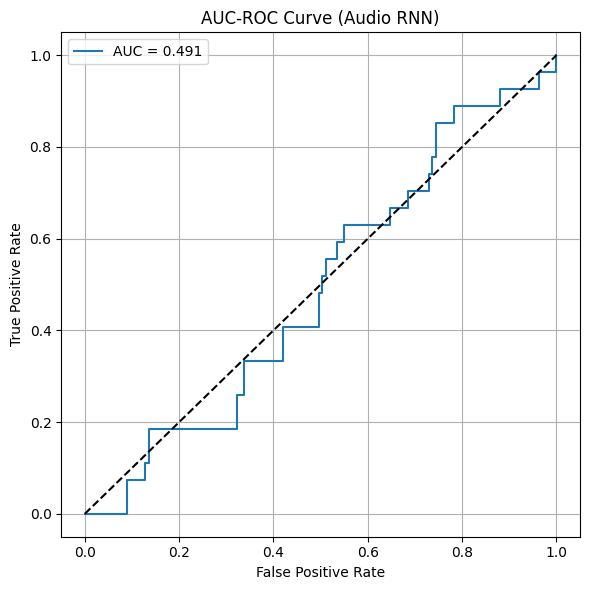

AUC-ROC curve saved to: /content/Alzheimers_RNN_XAI_Spectrogram/roc_curve.png


In [ ]:
# AUC-ROC Curve Plot#

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Make sure T (true labels) and Prob (predicted dementia probabilities) exist
# If not, recompute them using:
# _, P, Prob, T = eval_epoch(model, test_dl)

auc = roc_auc_score(T, Prob)
fpr, tpr, _ = roc_curve(T, Prob)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve (Audio RNN)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(SAVE_ROOT / "roc_curve.png", dpi=150)
plt.show()

print(f"AUC-ROC curve saved to: {SAVE_ROOT / 'roc_curve.png'}")


In [1]:
# Full robust multimodal (audio + text) pipeline with PyTorch RNN classifier

import os
import pathlib
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import librosa
from tqdm import tqdm
import joblib

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, confusion_matrix

# Mount Drive (works even if already mounted)
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
except Exception as e:
    # If not running in Colab, ignore
    pass

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# Config / Paths
BASE = pathlib.Path('/content/drive/MyDrive/Alzheimers_Organized')
CONTROL_DIR = BASE / 'control'
DEMENTIA_DIR = BASE / 'dementia'
SAVE_ROOT = pathlib.Path('/content/drive/MyDrive/Alzheimers_Multimodal_Model')
SAVE_ROOT.mkdir(parents=True, exist_ok=True)

print("Control exists:", CONTROL_DIR.exists(), "  Dementia exists:", DEMENTIA_DIR.exists())

# Helper: read transcript robustly
def read_transcript_for_wav(wav_path):
    """
    Try to find a transcript file matching wav basename.
    If not found or empty, return placeholder "speech_unavailable".
    """
    base = pathlib.Path(wav_path).with_suffix('')
    # Preferred transcript extensions (in order)
    exts = ['.txt', '.srt', '.vtt', '.csv', '.json']
    for ext in exts:
        p = base.with_suffix(ext)
        if p.exists():
            try:
                with open(p, 'r', errors='ignore') as f:
                    txt = f.read().strip()
                if len(txt) >= 3:
                    return txt
            except Exception:
                continue
    # If not found by exact basename, try to find any text file in same folder
    folder = base.parent
    for candidate in folder.iterdir():
        if candidate.suffix.lower() in {'.txt', '.srt', '.vtt', '.csv', '.json'}:
            try:
                with open(candidate, 'r', errors='ignore') as f:
                    txt = f.read().strip()
                if len(txt) >= 3:
                    return txt
            except Exception:
                continue
    # Fall back
    return "speech_unavailable"

# Collect dataset: wav + transcript + labels
pairs = []  # tuples (wav_path, transcript_text, label, filename)
for dirpath, label in [(CONTROL_DIR, 0), (DEMENTIA_DIR, 1)]:
    if not dirpath.exists():
        print(f"Warning: {dirpath} does not exist")
        continue
    # iterate recursively (in case files are in subfolders)
    for wav in sorted(dirpath.rglob("*.wav")):
        wav = pathlib.Path(wav)
        transcript = read_transcript_for_wav(wav)
        pairs.append((str(wav), transcript, label, wav.name))

print(f"Total audio-transcript pairs found: {len(pairs)}")
if len(pairs) == 0:
    raise SystemExit("No audio files found. Check your BASE path and folder structure.")

# AUDIO FEATURE: MFCC + delta + delta2 mean
N_MFCC = 40
MAX_DUR = None  # set if you want to limit duration (seconds); None -> full file

def compute_mfcc_features(wav_path, n_mfcc=N_MFCC, max_dur=MAX_DUR):
    y, sr = librosa.load(wav_path, sr=None, mono=True, duration=max_dur)
    if y is None or y.size == 0:
        # fallback to zeros
        y = np.zeros(16000)
        sr = 16000
    # MFCC: shape (n_mfcc, frames)
    m = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    # delta, delta2
    d = librosa.feature.delta(m)
    d2 = librosa.feature.delta(m, order=2)
    # concatenate along feature axis
    feat = np.concatenate([m, d, d2], axis=0)  # shape (n_mfcc*3, frames)
    # reduce variable time length by mean pooling (per feature)
    feat_mean = np.mean(feat, axis=1)  # shape (n_mfcc*3,)
    return feat_mean.astype(np.float32)

# TEXT FEATURE: TF-IDF with safe fallbacks
texts = [t for (_, t, _, _) in pairs]
# Pre-check: ensure at least some non-placeholder texts exist
usable_texts = [t for t in texts if t and t != "speech_unavailable" and len(t.strip())>2]

# Choose vectorizer robustly
vectorizer = None
if len(usable_texts) >= 2:
    # try TfidfVectorizer first; be tolerant
    try:
        vectorizer = TfidfVectorizer(max_features=500, stop_words=None, token_pattern=r"(?u)\b\w+\b")
        vectorizer.fit(texts)
        if len(vectorizer.get_feature_names_out()) == 0:
            raise ValueError("empty vocab")
        print("Using TfidfVectorizer; vocab size:", len(vectorizer.get_feature_names_out()))
    except Exception as e:
        print("Tfidf failed:", str(e), "-- falling back to CountVectorizer")
        try:
            vectorizer = CountVectorizer(max_features=500, token_pattern=r"(?u)\b\w+\b")
            vectorizer.fit(texts)
            print("Using CountVectorizer; vocab size:", len(vectorizer.get_feature_names_out()))
        except Exception as e2:
            print("CountVectorizer failed:", str(e2), "-- falling back to HashingVectorizer (stateless)")
            vectorizer = HashingVectorizer(n_features=500)
else:
    print("Not enough usable transcripts for TF-IDF (<=1). Using HashingVectorizer")
    vectorizer = HashingVectorizer(n_features=500)

# function to extract text features (works for TFIDF/Count/Hashing)
def extract_text_vector(text):
    try:
        v = vectorizer.transform([text])
        # if vectorizer is HashingVectorizer, transform returns sparse already; convert dense
        if hasattr(v, "toarray"):
            return v.toarray()[0].astype(np.float32)
        else:
            return np.array(v, dtype=np.float32)
    except Exception:
        # fallback to placeholder vector
        return np.zeros(getattr(vectorizer, "n_features", 500), dtype=np.float32)

# Build fused features array
audio_feats = []
text_feats = []
labels = []
filenames = []

print("Extracting features ...")
for wav_path, txt, lab, fname in tqdm(pairs):
    a = compute_mfcc_features(wav_path)
    t = extract_text_vector(txt)
    # ensure dims
    if a.ndim != 1:
        a = a.flatten()
    if t.ndim != 1:
        t = t.flatten()
    fused = np.concatenate([a, t]).astype(np.float32)
    audio_feats.append(a)
    text_feats.append(t)
    labels.append(int(lab))
    filenames.append(fname)

X = np.stack([np.concatenate([a, t]) for a, t in zip(audio_feats, text_feats)], axis=0)
y = np.array(labels, dtype=np.int64)

print("Fused feature shape:", X.shape, "Labels shape:", y.shape)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save vectorizer + scaler for later use
joblib.dump(vectorizer, SAVE_ROOT / "text_vectorizer.joblib")
joblib.dump(scaler, SAVE_ROOT / "feature_scaler.joblib")
print("Saved vectorizer and scaler to", SAVE_ROOT)

# Train/test split (stratified)
if len(np.unique(y)) == 1:
    raise SystemExit("Dataset has only one label class — cannot train classifier. Check your data folders.")

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Train/test sizes:", X_train.shape, X_test.shape)

# PyTorch Dataset & DataLoader
# We'll reshape features as (seq_len=1, feat_dim) for RNN input
class FusionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # RNN expects (batch, seq_len, feat_dim)
        return self.X[idx].unsqueeze(0), self.y[idx]

batch_size = 16
train_ds = FusionDataset(X_train, y_train)
test_ds = FusionDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size)

# RNN classifier (binary)
class RNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=1, bidirectional=False, dropout=0.2):
        super().__init__()
        # use Simple RNN; you can switch to nn.LSTM if desired
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, nonlinearity='tanh', dropout=0, bidirectional=bidirectional)
        out_dim = hidden_dim * (2 if bidirectional else 1)
        self.fc = nn.Sequential(
            nn.Linear(out_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)  # binary
        )

    def forward(self, x):
        # x: (batch, seq_len, feat_dim)
        out, h_n = self.rnn(x)  # out: (batch, seq_len, hidden*dirs)
        # take last timestep
        last = out[:, -1, :]
        logits = self.fc(last).squeeze(1)
        return logits

input_dim = X_train.shape[1]
model = RNNClassifier(input_dim=input_dim, hidden_dim=128, num_layers=1, bidirectional=True, dropout=0.3)
model = model.to(DEVICE)
print(model)

# Training setup
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
EPOCHS = 5

# Training loop
best_val_f1 = 0.0
best_state = None

for ep in range(1, EPOCHS+1):
    model.train()
    total_loss = 0.0
    for Xb, yb in train_loader:
        Xb = Xb.to(DEVICE)  # shape (B, 1, feat_dim)
        yb = yb.to(DEVICE).float()
        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item() * Xb.size(0)

    avg_loss = total_loss / len(train_ds)

    # Validation
    model.eval()
    preds = []
    probs = []
    trues = []
    with torch.no_grad():
        for Xb, yb in test_loader:
            Xb = Xb.to(DEVICE)
            logits = model(Xb)
            prob = torch.sigmoid(logits).cpu().numpy()
            pred = (prob > 0.5).astype(int)
            preds.extend(pred.tolist())
            probs.extend(prob.tolist())
            trues.extend(yb.numpy().tolist())

    try:
        val_acc = accuracy_score(trues, preds)
        val_f1 = f1_score(trues, preds, average='weighted')
    except Exception:
        val_acc = 0.0
        val_f1 = 0.0

    print(f"Epoch {ep}/{EPOCHS}  TrainLoss={avg_loss:.4f}  ValAcc={val_acc:.4f}  ValF1={val_f1:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_state = {
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "epoch": ep,
            "val_f1": val_f1
        }
        torch.save(best_state, SAVE_ROOT / "best_rnn_multimodal.pt")

# Load best & final evaluation
if best_state is not None:
    model.load_state_dict(best_state["model_state"])
    print("Loaded best model from epoch", best_state["epoch"], "val_f1=", best_state["val_f1"])

model.eval()
preds = []
probs = []
trues = []
filenames_test = []

with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(DEVICE)
        logits = model(Xb)
        prob = torch.sigmoid(logits).cpu().numpy()
        pred = (prob > 0.5).astype(int)
        probs.extend(prob.tolist())
        preds.extend(pred.tolist())
        trues.extend(yb.numpy().tolist())

print("\nClassification Report (test):")
print(classification_report(trues, preds, digits=4))
print("Confusion Matrix:\n", confusion_matrix(trues, preds))
print("Accuracy:", accuracy_score(trues, preds))
print("F1 weighted:", f1_score(trues, preds, average='weighted'))
# ROC AUC (if both classes present)
if len(np.unique(trues)) == 2:
    try:
        auc = roc_auc_score(trues, np.array(probs)[:, 0] if np.array(probs).ndim>1 else np.array(probs))
        print("ROC AUC:", auc)
    except Exception as e:
        print("ROC AUC could not be computed:", str(e))

# Save final artifacts
torch.save(model.state_dict(), SAVE_ROOT / "rnn_multimodal_final_state.pt")
joblib.dump(vectorizer, SAVE_ROOT / "text_vectorizer.joblib")
joblib.dump(scaler, SAVE_ROOT / "feature_scaler.joblib")
print("Saved final model and artifacts to", SAVE_ROOT)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Control exists: True   Dementia exists: True
Total audio-transcript pairs found: 368
Using TfidfVectorizer; vocab size: 500
Extracting features ...


100%|██████████| 368/368 [06:03<00:00,  1.01it/s]


Fused feature shape: (368, 620) Labels shape: (368,)
Saved vectorizer and scaler to /content/drive/MyDrive/Alzheimers_Multimodal_Model
Train/test sizes: (294, 620) (74, 620)
RNNClassifier(
  (rnn): RNN(620, 128, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
Epoch 1/5  TrainLoss=0.6954  ValAcc=0.5811  ValF1=0.5791
Epoch 2/5  TrainLoss=0.4999  ValAcc=0.6081  ValF1=0.6063
Epoch 3/5  TrainLoss=0.3199  ValAcc=0.6081  ValF1=0.6125
Epoch 4/5  TrainLoss=0.1659  ValAcc=0.6351  ValF1=0.6424
Epoch 5/5  TrainLoss=0.0698  ValAcc=0.6216  ValF1=0.6296
Loaded best model from epoch 4 val_f1= 0.6424310427357466

Classification Report (test):
              precision    recall  f1-score   support

           0     0.7500    0.6250    0.6818        48
           1     0.4706    0.6154    0.5333        26

    accurac